# Introduction

WeRateDogs is a twitter account that rates people's dogs with over 3.8 million followers. The ratings usually have a denominator of 10 with a numerator usually greater than the denominator, and this special rating system should take a big credit for the popularity of WeRateDogs.  

In this Jupyter notebook, we will wrangle data of WeRateDogs followed by some analysis and visualizations. This notebook is dividied into several sections:
- [Gathering Data](#gathering_data)
- [Assessing Data](#assessing_data)
- [Cleaning Data](#cleaning_data)
- [Storing Data](#storing_data) 
- [Analyzing and Visualizing Data](#analyzing_and_visualizing_data)

In [2]:
import pandas as pd
import os
import numpy as np
from IPython.display import display, HTML
import requests
import tweepy 
import time
import json
import missingno as msno
import pprint
import seaborn as sns
import datetime
import sqlite3
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('seaborn-notebook')

# Gathering Data <a id="gathering_data"></a>

## Data Sources

There are three different sources for the data:
-  WeRateDogs Twitter archive: twitter_archive_enhanced.csv
-  Tweet image prediction: [dog_URL](https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv)
-  Tweet information: ID, retweet count, and favorite count

## WeRateDogs Data

The archive of WeRateDogs account is already available in a CSV file. The only thing required is to read the CSV file in pandas's dataframe format.

In [3]:
# read the CSV file
we_rate_dogs = pd.read_csv("data/twitter-archive-enhanced.csv")

# check the first few lines 
we_rate_dogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

## Tweet Image Prediction

The tweet's image prediction is generated by a neutral network, and the results are stored in a TSV file. We download the TSV tweet image prediction file using Requests python library. We handle the Response object by setting 'utf-8' encoding and write the corresponding text into a txt file named as 'tweet_image_predictions', which is stored in the 'data' folder.

In [4]:
# we know the url
tweet_image_prediction_url = "https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"

# request from the url
folder = "data"
r = requests.get(tweet_image_prediction_url)
if r.status_code == requests.codes.ok:
    # to make sure to use utf-8 encoding
    r.encoding = 'utf-u' 
    
    # to store the file as a TSV file
    if not os.path.exists(folder):
        os.makedirs(folder)
    
    with open(os.path.join(folder, 'tweet_image_predictions.txt'), 'w') as infile:
        # write the text into the txt file
        infile.write(r.text)
    
    print('Requests are okay! The raw data is stored in tweet_image_predictions.txt')
    
# read the content using pandas 
tweet_image_predictions = pd.read_csv("data/tweet_image_predictions.txt", sep= '\t')

tweet_image_predictions.info()

Requests are okay! The raw data is stored in tweet_image_predictions.txt
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


## Tweet Information

There is extra information can be gathered from the twitter API. The Python twitter API, tweepy, is used for simpler and more robust data extraction. For each tweet ID in the we_rate_dogs and tweet_image_predicitons tables, the entire JSON data about the tweet is downloaded by setting a correct parser (JSONParser). The tweet JSON information is stored in a Python dictionary using the tweet ID as a key. Finally, we write the JSON information into a txt file (tweet_json.txt) in which each line represents one JSON record of the tweet.

In [6]:
# put your persoanl APT key and login information
#consumer_key = 
#consumer_secret = 
#access_token = 
#access_secret = 

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

# create api object
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True,
                 parser=tweepy.parsers.JSONParser())

# get the tweet IDs from the we_rate_dogs and image predictions dataframes
tweet_IDs = np.array(we_rate_dogs['tweet_id'].values, dtype = str)
tweet_IDs = np.concatenate((np.array(tweet_image_predictions['tweet_id'].values,
                                     dtype = str), tweet_IDs))
tweet_IDs = np.unique(tweet_IDs)

# get the tweets
tweets = {}

for tweet_id in tweet_IDs:
    start = time.time()
    try:
        tweets[tweet_id] = api.get_status(tweet_id, tweet_mode = 'extended')
    except tweepy.TweepError as e:
        print(e)
    end = time.time()
    request_time = end - start
    print("time required: ", request_time)

# store each tweet of JSON data in a file called tweet_json.txt file
with open(os.path.join(folder, 'tweet_json.txt'), 'w', encoding='utf-8') as outfile:
    for key, value in tweets.items():
        json.dump(value, outfile)
        outfile.write('\n') # data should be written to its own line       

time required:  0.2530555725097656
time required:  0.23588299751281738
time required:  0.23075294494628906
time required:  0.3095738887786865
time required:  0.2184457778930664
time required:  0.2335960865020752
time required:  0.24429106712341309
time required:  0.23160552978515625
time required:  0.21658945083618164
time required:  0.21391916275024414
time required:  0.2262723445892334
time required:  0.23070311546325684
time required:  0.20816493034362793
time required:  0.20135283470153809
time required:  0.23630070686340332
time required:  0.3277766704559326
time required:  0.24002885818481445
time required:  0.20917892456054688
time required:  0.20081305503845215
time required:  0.22767400741577148
time required:  0.2347099781036377
time required:  0.2184920310974121
time required:  0.24074482917785645
time required:  0.3593578338623047
time required:  0.2691664695739746
time required:  0.460573673248291
time required:  0.21599531173706055
time required:  0.2281498908996582
time 

time required:  0.22152113914489746
time required:  0.2629404067993164
time required:  0.2217576503753662
time required:  0.23365497589111328
time required:  0.2503235340118408
time required:  0.23197531700134277
time required:  0.22941827774047852
time required:  0.2125110626220703
time required:  0.23255705833435059
time required:  0.2167043685913086
time required:  0.22038841247558594
time required:  0.21498465538024902
time required:  0.2131791114807129
time required:  0.23730134963989258
time required:  0.29822754859924316
time required:  0.20737481117248535
time required:  0.21306371688842773
time required:  0.26039838790893555
time required:  0.2241194248199463
time required:  0.23791050910949707
time required:  0.21854305267333984
time required:  0.2465507984161377
time required:  0.2181847095489502
time required:  0.2667815685272217
time required:  0.23113799095153809
time required:  0.2100682258605957
time required:  0.22866177558898926
time required:  0.2414095401763916
time

time required:  0.2242598533630371
time required:  0.22990822792053223
time required:  0.24806761741638184
time required:  0.20934128761291504
time required:  0.2762618064880371
time required:  0.2854485511779785
time required:  0.22245454788208008
time required:  0.23160815238952637
time required:  0.2017502784729004
time required:  0.25602221488952637
time required:  0.22893500328063965
time required:  0.21896624565124512
time required:  0.23444223403930664
time required:  0.24498891830444336
time required:  0.22428417205810547
time required:  0.21355128288269043
time required:  0.22813868522644043
time required:  0.22232270240783691
time required:  0.21724891662597656
time required:  0.19938015937805176
time required:  0.2331867218017578
time required:  0.260589599609375
time required:  0.34824395179748535
time required:  0.24115347862243652
time required:  0.2281475067138672
time required:  0.20804357528686523
time required:  0.234602689743042
time required:  0.274153470993042
time

time required:  0.2249150276184082
time required:  0.22108888626098633
time required:  0.2049236297607422
time required:  0.2228984832763672
time required:  0.5609283447265625
time required:  0.2405869960784912
time required:  0.2098984718322754
time required:  0.24449467658996582
time required:  0.24744057655334473
time required:  0.22968411445617676
time required:  0.21828603744506836
time required:  0.24220967292785645
time required:  0.22201919555664062
time required:  0.22189998626708984
time required:  0.24726510047912598
time required:  0.27626824378967285
time required:  0.2263660430908203
time required:  0.22306108474731445
time required:  0.2241208553314209
time required:  0.20587849617004395
time required:  0.3142671585083008
time required:  0.24001216888427734
time required:  0.20763087272644043
time required:  0.22648978233337402
time required:  0.25605297088623047
time required:  0.24452424049377441
time required:  0.2557990550994873
time required:  0.20134902000427246
ti

time required:  0.22195911407470703
time required:  0.219146728515625
time required:  0.22534728050231934
time required:  0.25661587715148926
time required:  0.22519350051879883
time required:  0.21338796615600586
time required:  0.23174405097961426
time required:  0.5216038227081299
time required:  0.23162603378295898
time required:  0.2762112617492676
time required:  0.23057341575622559
time required:  0.23986506462097168
time required:  0.23471999168395996
time required:  0.4786031246185303
time required:  0.21985793113708496
time required:  0.24290037155151367
time required:  0.23636627197265625
time required:  0.22045087814331055
time required:  0.3748176097869873
time required:  0.22703886032104492
time required:  0.31046080589294434
time required:  0.22469329833984375
time required:  0.25583362579345703
time required:  0.22538280487060547
time required:  0.22776293754577637
time required:  0.2029426097869873
time required:  0.2433173656463623
time required:  0.22930097579956055


time required:  0.23334455490112305
time required:  0.2281324863433838
time required:  0.23671746253967285
time required:  0.21770954132080078
time required:  0.22457051277160645
time required:  0.21225357055664062
time required:  0.21594619750976562
time required:  0.2547774314880371
time required:  0.23927068710327148
time required:  0.259868860244751
time required:  0.2410433292388916
time required:  0.264756441116333
time required:  0.2328016757965088
time required:  0.30480074882507324
time required:  0.21285057067871094
time required:  0.25684118270874023
time required:  0.2749593257904053
time required:  0.2535684108734131
time required:  0.21542716026306152
time required:  0.219681978225708
time required:  0.23320937156677246
time required:  0.25862646102905273
time required:  0.2621462345123291
time required:  0.26102161407470703
time required:  0.24181294441223145
time required:  0.2967805862426758
time required:  0.2539687156677246
time required:  0.23320364952087402
time re

time required:  0.23261332511901855
time required:  0.2275240421295166
time required:  0.24335289001464844
time required:  0.2139439582824707
time required:  0.21426892280578613
time required:  0.21825528144836426
time required:  0.23766446113586426
time required:  0.22141742706298828
time required:  0.22325348854064941
time required:  0.24916958808898926
time required:  0.21457195281982422
time required:  0.2420358657836914
time required:  0.2304701805114746
time required:  0.21854877471923828
time required:  0.22664880752563477
time required:  0.2511916160583496
time required:  0.2545027732849121
time required:  0.2193598747253418
time required:  0.21768856048583984
time required:  0.25428318977355957
time required:  0.22733187675476074
time required:  0.23466229438781738
time required:  0.2950558662414551
time required:  0.3142099380493164
time required:  0.24030613899230957
time required:  0.2632260322570801
time required:  0.21548080444335938
time required:  0.26973485946655273
ti

time required:  0.2450120449066162
time required:  0.2122340202331543
time required:  0.24265003204345703
time required:  0.21689319610595703
time required:  0.24999451637268066
time required:  0.358090877532959
time required:  0.21413469314575195
time required:  0.23006772994995117
time required:  0.22651100158691406
time required:  0.21118712425231934
time required:  0.23732209205627441
time required:  0.25144267082214355
time required:  0.23061728477478027
time required:  0.23468518257141113
time required:  0.2562253475189209
time required:  0.26187658309936523
time required:  0.25576019287109375
time required:  0.24713587760925293
time required:  0.2250664234161377
time required:  0.2790083885192871
time required:  0.24321532249450684
time required:  0.2668492794036865
time required:  0.22286605834960938
time required:  0.22101187705993652
time required:  0.26334095001220703
time required:  0.22563767433166504
time required:  0.29028773307800293
time required:  0.33800554275512695


time required:  0.31239748001098633
time required:  0.26233792304992676
time required:  0.2466142177581787
time required:  0.3192758560180664
time required:  0.2339179515838623
time required:  0.2200336456298828
time required:  0.25320959091186523
time required:  0.2581923007965088
time required:  0.2402946949005127
time required:  0.22200703620910645
time required:  0.24399089813232422
time required:  0.24131512641906738
time required:  0.23299694061279297
time required:  0.22699522972106934
time required:  0.2472691535949707
time required:  0.20225262641906738
time required:  0.23435616493225098
time required:  0.2928192615509033
time required:  0.23761773109436035
time required:  0.5316970348358154
time required:  0.21706748008728027
time required:  0.23055386543273926
time required:  0.22407221794128418
time required:  0.25191664695739746
time required:  0.2369236946105957
time required:  0.2621738910675049
time required:  0.39467358589172363
time required:  0.27036285400390625
tim

time required:  0.20812058448791504
time required:  0.21541261672973633
time required:  0.24094247817993164
time required:  0.23015618324279785
time required:  0.22235536575317383
time required:  0.25286102294921875
time required:  0.25948309898376465
time required:  0.22727108001708984
time required:  0.241668701171875
time required:  0.24237966537475586
time required:  0.21764850616455078
time required:  0.2409663200378418
time required:  0.3076174259185791
time required:  0.25832319259643555
time required:  0.20907807350158691
time required:  0.3251361846923828
time required:  0.23680424690246582
time required:  0.22012615203857422
time required:  0.2307755947113037
time required:  0.2337656021118164
time required:  0.27051234245300293
time required:  0.21543431282043457
time required:  0.45245909690856934
time required:  0.22718000411987305
time required:  0.22792410850524902
time required:  0.24728798866271973
time required:  0.2131941318511963
time required:  0.23351669311523438


time required:  0.24580144882202148
time required:  0.21633362770080566
time required:  0.2284379005432129
time required:  0.23201227188110352
time required:  0.22205567359924316
time required:  0.28542542457580566
time required:  0.23539948463439941
time required:  0.20793867111206055
time required:  0.23163747787475586
time required:  0.2125873565673828
time required:  0.2342231273651123
time required:  0.21994709968566895
time required:  0.22597789764404297
time required:  0.2378692626953125
time required:  0.2523336410522461
time required:  0.2439572811126709
time required:  0.2216329574584961
time required:  0.2146899700164795
time required:  0.2311406135559082
time required:  0.2182314395904541
time required:  0.19774317741394043
time required:  0.2833700180053711
time required:  0.2553977966308594
time required:  0.22762227058410645
time required:  0.46653127670288086
time required:  0.23792290687561035
time required:  0.2397301197052002
time required:  0.2648477554321289
time r

We then can extract the required information, the retweet and favorite counts of the tweet. The required information is finally transformed into Pandas dataframe (tweets_data).

In [7]:
# create an empty list to store the data extracted from tweet JSON data
tweets_list = []

with open(os.path.join(folder, 'tweet_json.txt'), 'r', encoding='utf-8') as file:
    count = 0
    for line in file:
        # load the JSON formatted string to dictionary
        data = json.loads(line)
        
        # pprint for one example
        if count == 0:
            pp = pprint.PrettyPrinter(indent=4)
            pp.pprint(data)
        count += 1

        # get the variables of interest
        tweet_id = data['id_str']
        retweet_count = data['retweet_count']
        favorite_count = data['favorite_count']
        
        # append the extracted information into the list
        tweets_list.append({'tweet_id': tweet_id, 
                            'retweet_count': retweet_count,
                            'favorite_count': favorite_count})

# turn the list into a dataframe
tweets_data = pd.DataFrame(tweets_list, 
                           columns = ['tweet_id', 'retweet_count', 
                                      'favorite_count'])

# show the first few lines 
tweets_data.info()

{   'contributors': None,
    'coordinates': None,
    'created_at': 'Mon Nov 23 04:59:42 +0000 2015',
    'display_text_range': [0, 112],
    'entities': {   'hashtags': [],
                    'media': [   {   'display_url': 'pic.twitter.com/mwnBN6ZkPt',
                                     'expanded_url': 'https://twitter.com/dog_rates/status/668655139528511488/photo/1',
                                     'id': 668655136865181697,
                                     'id_str': '668655136865181697',
                                     'indices': [89, 112],
                                     'media_url': 'http://pbs.twimg.com/media/CUeKTeYW4AEr_lx.jpg',
                                     'media_url_https': 'https://pbs.twimg.com/media/CUeKTeYW4AEr_lx.jpg',
                                     'sizes': {   'large': {   'h': 1024,
                                                               'resize': 'fit',
                                                               'w': 577

# Assessing Data <a id="assessing_data"></a>
In this section, we will assess the data to identify the issues about data quality and tidiness on three datasets:
-  we_rate_dogs
-  tweet_image_predictions
-  tweets_data

## we_rate_dogs

In [8]:
we_rate_dogs.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
120,869702957897576449,NaN,NaN,2017-05-30 23:51:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Stanley. He likes road trips. Will shift ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/869702957...,13,10,Stanley,None,None,None,None
2012,672239279297454080,NaN,NaN,2015-12-03 02:21:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Ridley. He doesn't know how to couch. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672239279...,7,10,Ridley,None,None,None,None
1278,708853462201716736,NaN,NaN,2016-03-13 03:13:29 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Lucy. She doesn't understand fetch. 8/...,NaN,NaN,NaN,https://vine.co/v/iHl2UDEBZ95,8,10,Lucy,None,None,None,None
2103,670676092097810432,NaN,NaN,2015-11-28 18:50:15 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bloo. He's a Westminster Cîroc. Doesn'...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670676092...,8,10,Bloo,None,None,None,None
1975,672997845381865473,NaN,NaN,2015-12-05 04:36:04 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Say hello to Kenzie. She is a fluff ball. 12/1...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/672997845...,12,10,Kenzie,None,None,None,None


In [9]:
we_rate_dogs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [10]:
# the variables in we_rate_dogs
list(we_rate_dogs)

['tweet_id',
 'in_reply_to_status_id',
 'in_reply_to_user_id',
 'timestamp',
 'source',
 'text',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

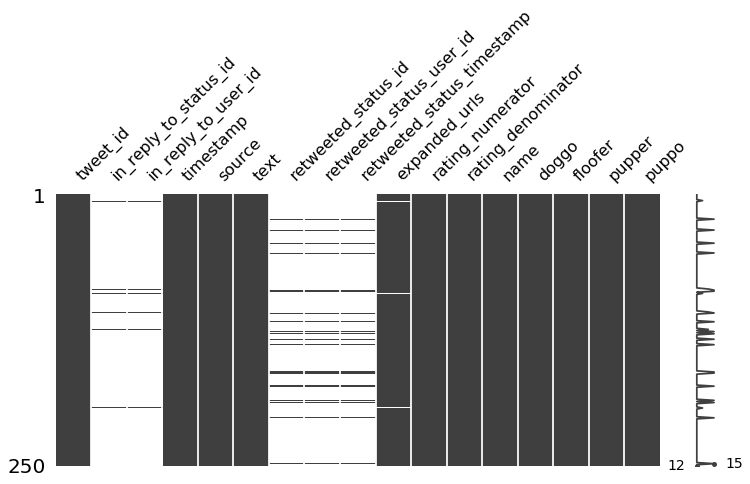

In [11]:
msno.matrix(we_rate_dogs.sample(250), figsize= (12,5))

In [12]:
we_rate_dogs[we_rate_dogs['rating_numerator'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [13]:
we_rate_dogs.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [14]:
we_rate_dogs[we_rate_dogs['tweet_id'].duplicated()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [15]:
we_rate_dogs[we_rate_dogs['doggo'] != 'None']

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None
43,884162670584377345,NaN,NaN,2017-07-09 21:29:42 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Yogi. He doesn't have any important dog m...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/884162670...,12,10,Yogi,doggo,None,None,None
99,872967104147763200,NaN,NaN,2017-06-09 00:02:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a very large dog. He has a date later. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/872967104...,12,10,None,doggo,None,None,None
108,871515927908634625,NaN,NaN,2017-06-04 23:56:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Napolean. He's a Raggedy East Nicaragu...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/871515927...,12,10,Napolean,doggo,None,None,None
110,871102520638267392,NaN,NaN,2017-06-03 20:33:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Never doubt a doggo 14/10 https://t.co/AbBLh2FZCH,NaN,NaN,NaN,https://twitter.com/animalcog/status/871075758...,14,10,None,doggo,None,None,None
121,869596645499047938,NaN,NaN,2017-05-30 16:49:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Scout. He just graduated. Officially a...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/869596645...,12,10,Scout,doggo,None,None,None
172,858843525470990336,NaN,NaN,2017-05-01 00:40:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I have stumbled puppon a doggo painting party....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/858843525...,13,10,None,doggo,None,None,None
191,855851453814013952,NaN,NaN,2017-04-22 18:31:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here's a puppo participating in the #ScienceMa...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/855851453...,13,10,None,doggo,None,None,puppo
200,854010172552949760,NaN,NaN,2017-04-17 16:34:26 +0000,"<a href=""http://twitter.com/download/iphone"" r...","At first I thought this was a shy doggo, but i...",NaN,NaN,NaN,https://twitter.com/dog_rates/status/854010172...,11,10,None,doggo,floofer,None,None
211,851953902622658560,NaN,NaN,2017-04-12 00:23:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Astrid. She's a guide d...,8.293743e+17,4.196984e+09,2017-02-08 17:00:26 +0000,https://twitter.com/dog_rates/status/829374341...,13,10,Astrid,doggo,None,None,None


In [16]:
we_rate_dogs['source'].value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [17]:
we_rate_dogs[we_rate_dogs['rating_denominator'] < 10]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
313,835246439529840640,8.352460e+17,26259576.0,2017-02-24 21:54:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@jonnysun @Lin_Manuel ok jomny I know you're e...,NaN,NaN,NaN,NaN,960,0,None,None,None,None,None
516,810984652412424192,NaN,NaN,2016-12-19 23:06:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Sam. She smiles 24/7 &amp; secretly aspir...,NaN,NaN,NaN,"https://www.gofundme.com/sams-smile,https://tw...",24,7,Sam,None,None,None,None
2335,666287406224695296,NaN,NaN,2015-11-16 16:11:11 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is an Albanian 3 1/2 legged Episcopalian...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666287406...,1,2,an,None,None,None,None


There are several issues are identified based on a quick data assessing, and we discuss them in two dimensions: quality and tidiness. 

The quality issues are:
> - we want to focus on the original ratings. We should be able to identify the original ratings based on the variables like retweeted_status_user_id etc.
> - there is missing data in variables: name, doggo, floofer, pupper, and puppo.
> - 'None' in the dataset should be replaced by 'NaN' for better handling.
> - there are wrong data types: tweet_id and timestamp
> - source: turns the HTML text into something with better meaning such as 'Twitter for iPhone'

Tidiness issues:
> - doggo, floofer, pupper, and puppo should be one variable

## tweet_image_predictions

In [18]:
tweet_image_predictions.sample(6)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
943,704347321748819968,https://pbs.twimg.com/media/CcZYJniXEAAEJRF.jpg,1,teddy,0.233378,False,feather_boa,0.088474,False,Brittany_spaniel,0.082917,True
2049,887101392804085760,https://pbs.twimg.com/media/DE-eAq6UwAA-jaE.jpg,1,Samoyed,0.733942,True,Eskimo_dog,0.035029,True,Staffordshire_bullterrier,0.029705,True
827,693486665285931008,https://pbs.twimg.com/ext_tw_video_thumb/69348...,1,sea_lion,0.519811,False,Siamese_cat,0.290971,False,black-footed_ferret,0.039967,False
1824,835152434251116546,https://pbs.twimg.com/media/C5cOtWVWMAEjO5p.jpg,3,swing,0.967066,False,American_Staffordshire_terrier,0.012731,True,Staffordshire_bullterrier,0.007039,True
524,676603393314578432,https://pbs.twimg.com/media/CWPHMqKVAAAE78E.jpg,1,whippet,0.877021,True,Great_Dane,0.034182,True,boxer,0.028404,True
429,674265582246694913,https://pbs.twimg.com/media/CVt49k_WsAAtNYC.jpg,1,slug,0.998075,False,ice_lolly,0.000984,False,leafhopper,0.000097,False


In [19]:
tweet_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [20]:
tweet_image_predictions.describe()

,tweet_id,img_num,p1_conf,p2_conf,p3_conf
count,2.075000e+03,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.384514e+17,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.785203e+16,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.764835e+17,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.119988e+17,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.932034e+17,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,4.000000,1.000000,4.880140e-01,2.734190e-01


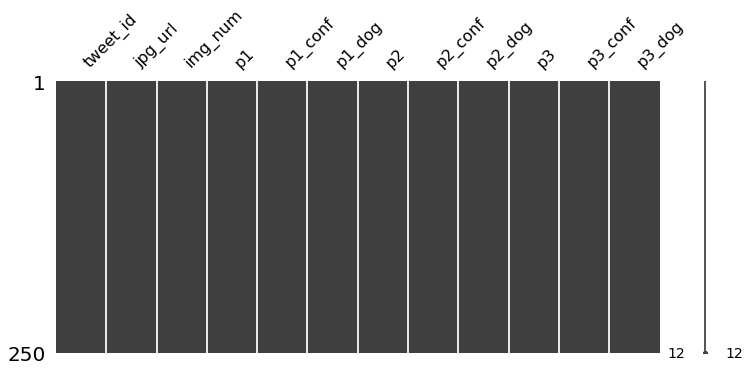

In [21]:
msno.matrix(tweet_image_predictions.sample(250), figsize= (12,5))

In [22]:
tweet_image_predictions['p1'].value_counts()

golden_retriever             150
Labrador_retriever           100
Pembroke                      89
Chihuahua                     83
pug                           57
chow                          44
Samoyed                       43
toy_poodle                    39
Pomeranian                    38
cocker_spaniel                30
malamute                      30
French_bulldog                26
miniature_pinscher            23
Chesapeake_Bay_retriever      23
seat_belt                     22
Siberian_husky                20
Staffordshire_bullterrier     20
German_shepherd               20
Cardigan                      19
web_site                      19
beagle                        18
Eskimo_dog                    18
teddy                         18
Maltese_dog                   18
Shetland_sheepdog             18
Shih-Tzu                      17
Lakeland_terrier              17
Rottweiler                    17
Italian_greyhound             16
kuvasz                        16
          

In [23]:
tweet_image_predictions[tweet_image_predictions['p1'] == 'remote_control']

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1527,788908386943430656,https://pbs.twimg.com/media/CvLD-mbWYAAFI8w.jpg,1,remote_control,0.881538,False,oscilloscope,0.035513,False,golden_retriever,0.03409,True


We identify several issues about the quality and tidiness of the tweet_image_predictions.

First, there are one quality issue about the data types:
> - tweet_id should string
> - p1, p2, and p3 should be categorical data

Second, there is two tidiness issue:
> - p1, p2, and p3 should be one variables, i.e., the ranking of the prediction based on neutral network 
> - name of column such as p1_conf and p1_dog are not meaningful

## tweets_data

In [24]:
tweets_data.sample(6)

,tweet_id,retweet_count,favorite_count
1073,691820333922455552,1846,4300
1872,832682457690300417,3339,12958
365,760539183865880579,4132,8344
70,812709060537683968,1658,7340
140,669571471778410496,1075,1679
1706,854120357044912130,8224,33738


In [25]:
tweets_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2351 entries, 0 to 2350
Data columns (total 3 columns):
tweet_id          2351 non-null object
retweet_count     2351 non-null int64
favorite_count    2351 non-null int64
dtypes: int64(2), object(1)
memory usage: 55.2+ KB


In [26]:
tweets_data.describe()

,retweet_count,favorite_count
count,2351.000000,2351.000000
mean,3130.317312,8110.228413
std,5237.090199,11986.138770
min,0.000000,0.000000
25%,617.000000,1419.000000
50%,1452.000000,3595.000000
75%,3621.000000,10113.500000
max,78990.000000,132135.000000


The tweets_data should be a subset of we_rate_dogs table since it contains the information related with the tweets in WeRateDogs.

# Cleaning Data <a id="cleaning_data"></a>

## we_rate_dogs

We start the data cleaning by copying the dataframe and labelling it as a clean version.

In [27]:
# make a copy 
we_rate_dogs_clean = we_rate_dogs.copy()

### Definiation 1
We want to focus on the original ratings. We should ignore the data in which its retweeted_status_user_id and in_reply_to_user_id are null. Then, we can drop the variables related with the retweeted_status_user_id and in_reply_to_user_id. 

In [28]:
# we only need the original ratings
we_rate_dogs_clean = we_rate_dogs_clean[we_rate_dogs_clean['retweeted_status_id'].isnull()]
we_rate_dogs_clean = we_rate_dogs_clean[we_rate_dogs_clean['in_reply_to_user_id'].isnull()]

In [29]:
# test the results
we_rate_dogs_clean[we_rate_dogs_clean['retweeted_status_id'].notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [30]:
# test the results
we_rate_dogs_clean[we_rate_dogs_clean['in_reply_to_user_id'].notnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


In [31]:
# we can then delete the retweet columns 
we_rate_dogs_clean = we_rate_dogs_clean.drop(['in_reply_to_user_id', 'in_reply_to_status_id', 'retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1)

In [32]:
list(we_rate_dogs_clean)

['tweet_id',
 'timestamp',
 'source',
 'text',
 'expanded_urls',
 'rating_numerator',
 'rating_denominator',
 'name',
 'doggo',
 'floofer',
 'pupper',
 'puppo']

### Definition 2
The 'source' variable should be categorical and has four elements: Twitter for iPhone, Vine - Make a Scene, Twitter Web Client, TweetDeck. We first extract the correct elements from the HTML text, and then cast the data types to 'category'.

In [33]:
# extract the text between '>' and '</a>
we_rate_dogs_clean['source'] = we_rate_dogs_clean['source'].str.extract('>(.*?)</a>', expand= True)

# correct the data type
we_rate_dogs_clean = we_rate_dogs_clean.astype({'source': "category"})

In [34]:
we_rate_dogs_clean['source'].value_counts()

Twitter for iPhone     1964
Vine - Make a Scene      91
Twitter Web Client       31
TweetDeck                11
Name: source, dtype: int64

### Definition 3
We replace all the 'None' into 'NaN'.

In [35]:
# replace the 'None' to np.nan
we_rate_dogs_clean = we_rate_dogs_clean.replace('None', np.nan)

In [36]:
we_rate_dogs_clean[we_rate_dogs_clean['name'] == 'None']

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo


### Definition 4
We correct the data types of 'tweet_id' and 'timestamp'.

In [37]:
# correct the data types
we_rate_dogs_clean = we_rate_dogs_clean.astype({'tweet_id': str})
we_rate_dogs_clean['timestamp'] = pd.to_datetime(we_rate_dogs_clean['timestamp'])

# rename the series to date
we_rate_dogs_clean = we_rate_dogs_clean.rename(columns = {'timestamp':'datetime'})

In [38]:
we_rate_dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 12 columns):
tweet_id              2097 non-null object
datetime              2097 non-null datetime64[ns]
source                2097 non-null category
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  1494 non-null object
doggo                 83 non-null object
floofer               10 non-null object
pupper                230 non-null object
puppo                 24 non-null object
dtypes: category(1), datetime64[ns](1), int64(2), object(8)
memory usage: 198.8+ KB


### Definition 5 
Finally, we meet the tidiness issue. We create a new column from columns 'doggo', 'floofer', 'pupper', and 'puppo' and label it as 'dog_stages'. Since the 'dog_stages' contains the stages of the dog, in which the variable should be ordered. Therefore, we assign a order for 'dog_stages': 'pupper' < 'puppo' < 'doggo' < 'floofer'. Then, we drop four original columns: 'pupper','puppo','doggo', and 'floofer'. 

In [39]:
# function to create the value in new column
def get_dog_stages(row):
    value = np.nan
    for c in ['doggo', 'floofer', 'pupper', 'puppo']:
        if row[c] == 'doggo':
            value = 'doggo'
        elif row[c] == 'floofer':
            value = 'floofer'
        elif row[c] == 'pupper':
            value = 'pupper'
        elif row[c] == 'puppo':
            value = 'puppo'
    return value

# get a new series
new_series = we_rate_dogs_clean.apply(get_dog_stages, axis =1 )
we_rate_dogs_clean = we_rate_dogs_clean.assign(dog_stages = new_series)

# correct the data type
we_rate_dogs_clean = we_rate_dogs_clean.astype({'dog_stages': "category"})
we_rate_dogs_clean['dog_stages'] = we_rate_dogs_clean.dog_stages.cat.set_categories(['pupper','puppo','doggo','floofer'], ordered=True)

In [40]:
we_rate_dogs_clean[we_rate_dogs_clean['dog_stages'].notnull()][['doggo', 'floofer', 'pupper', 'puppo', 'dog_stages']]

,doggo,floofer,pupper,puppo,dog_stages
9,doggo,NaN,NaN,NaN,doggo
12,NaN,NaN,NaN,puppo,puppo
14,NaN,NaN,NaN,puppo,puppo
29,NaN,NaN,pupper,NaN,pupper
43,doggo,NaN,NaN,NaN,doggo
46,NaN,floofer,NaN,NaN,floofer
49,NaN,NaN,pupper,NaN,pupper
56,NaN,NaN,pupper,NaN,pupper
71,NaN,NaN,NaN,puppo,puppo
82,NaN,NaN,pupper,NaN,pupper


In [41]:
# delete the extra columns on dog stages
we_rate_dogs_clean = we_rate_dogs_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis =1)

In [42]:
we_rate_dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2355
Data columns (total 9 columns):
tweet_id              2097 non-null object
datetime              2097 non-null datetime64[ns]
source                2097 non-null category
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  1494 non-null object
dog_stages            336 non-null category
dtypes: category(2), datetime64[ns](1), int64(2), object(4)
memory usage: 135.5+ KB


### Definition 6
We merge the tweets_data into the we_rate_dogs.

In [43]:
# merge two dataframes
we_rate_dogs_clean = pd.merge(we_rate_dogs_clean, tweets_data, how='left', on='tweet_id')

In [44]:
we_rate_dogs_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2097 entries, 0 to 2096
Data columns (total 11 columns):
tweet_id              2097 non-null object
datetime              2097 non-null datetime64[ns]
source                2097 non-null category
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  1494 non-null object
dog_stages            336 non-null category
retweet_count         2097 non-null int64
favorite_count        2097 non-null int64
dtypes: category(2), datetime64[ns](1), int64(4), object(4)
memory usage: 168.3+ KB


## tweet_image_predictions

Again, we copy the tweet_image_predictions before cleaning the data.

In [45]:
# make a copy 
tweet_image_predictions_clean = tweet_image_predictions.copy()

### Definiation 1
We correct the data types. 

In [46]:
tweet_image_predictions_clean = tweet_image_predictions_clean.astype({'tweet_id': str})

In [47]:
tweet_image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


### Definiation 2
There are 9 columns related with the dog predictions, and we would like to stack these columns by using the prediction rank of the images. After stacking, we have two new categorical columns called 'prediction_rank' which stores the rank of the prediction and 'breed' which stores the breed of the dog predictions. Also, we rename the columns '\*_conf' and '\*_dog' into 'confidence' and 'is_dog_breed'.

In [48]:
# set columns that don't change as index
tweet_image_predictions_clean.set_index(['tweet_id', 'jpg_url', 'img_num'], inplace=True)

# create multi-index columns
arrays = [['breed', 'confidence', 'is_dog_breed']*3,
         ['First']*3 + ['Second']*3 + ['Third']*3]
names = ('properties','prediction_rank')

tweet_image_predictions_clean.columns = pd.MultiIndex.from_arrays(arrays, names = names)

In [49]:
# transform the multi-index data frames to long format with stack
tweet_image_predictions_clean = tweet_image_predictions_clean.stack(level=1)
names = ('tweet_id', 'jpg_url', 'img_num', 'prediction_rank')
tweet_image_predictions_clean = tweet_image_predictions_clean.rename_axis(names)
tweet_image_predictions_clean = tweet_image_predictions_clean.reset_index()


In [50]:
# correct the data types
tweet_image_predictions_clean = tweet_image_predictions_clean.astype({'prediction_rank': 'category', 'breed': 'category'})

In [51]:
tweet_image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6225 entries, 0 to 6224
Data columns (total 7 columns):
tweet_id           6225 non-null object
jpg_url            6225 non-null object
img_num            6225 non-null int64
prediction_rank    6225 non-null category
breed              6225 non-null category
confidence         6225 non-null float64
is_dog_breed       6225 non-null bool
dtypes: bool(1), category(2), float64(1), int64(1), object(2)
memory usage: 244.0+ KB


# Storing Data <a id="storing_data"></a>
We store two cleaned tables into 'we_rate_dogs.sqlite' database.

In [52]:
# define the dataase
sqlite_file = 'we_rate_dogs.sqlite'
table1 = 'twitter_achive_master'
table2 = 'twitter_image_prediction'

# Connecting to the database file
conn = sqlite3.connect(os.path.join(folder, sqlite_file))
c = conn.cursor()

# write the table 1 from pandas
we_rate_dogs_clean.to_sql(table1, conn, index= False, if_exists='replace')
tweet_image_predictions_clean.to_sql(table2, conn, index= False, if_exists='replace')

conn.commit()
conn.close()


In [53]:
# to test the database

# getting data
conn = sqlite3.connect(os.path.join(folder, sqlite_file))

# read the dataframe
twitters = pd.read_sql('select * from twitter_achive_master', conn)
predictions = pd.read_sql('select * from twitter_image_prediction', conn)

conn.close()

print(twitters.info())
print(predictions.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2097 entries, 0 to 2096
Data columns (total 11 columns):
tweet_id              2097 non-null object
datetime              2097 non-null object
source                2097 non-null object
text                  2097 non-null object
expanded_urls         2094 non-null object
rating_numerator      2097 non-null int64
rating_denominator    2097 non-null int64
name                  1494 non-null object
dog_stages            336 non-null object
retweet_count         2097 non-null int64
favorite_count        2097 non-null int64
dtypes: int64(4), object(7)
memory usage: 180.3+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6225 entries, 0 to 6224
Data columns (total 7 columns):
tweet_id           6225 non-null object
jpg_url            6225 non-null object
img_num            6225 non-null int64
prediction_rank    6225 non-null object
breed              6225 non-null object
confidence         6225 non-null float64
is_dog_breed       622

# Analyzing and Visualizing Data <a id= "analyzing_and_visualizing_data"></a>

In [54]:
twitters = we_rate_dogs_clean.copy()
predictions = tweet_image_predictions_clean.copy()

In [55]:
# merge the file for conivent search
master = pd.merge(twitters, predictions, how='left', on='tweet_id')

master.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6039 entries, 0 to 6038
Data columns (total 17 columns):
tweet_id              6039 non-null object
datetime              6039 non-null datetime64[ns]
source                6039 non-null category
text                  6039 non-null object
expanded_urls         6036 non-null object
rating_numerator      6039 non-null int64
rating_denominator    6039 non-null int64
name                  4388 non-null object
dog_stages            942 non-null category
retweet_count         6039 non-null int64
favorite_count        6039 non-null int64
jpg_url               5913 non-null object
img_num               5913 non-null float64
prediction_rank       5913 non-null category
breed                 5913 non-null category
confidence            5913 non-null float64
is_dog_breed          5913 non-null object
dtypes: category(4), datetime64[ns](1), float64(2), int64(4), object(6)
memory usage: 715.4+ KB


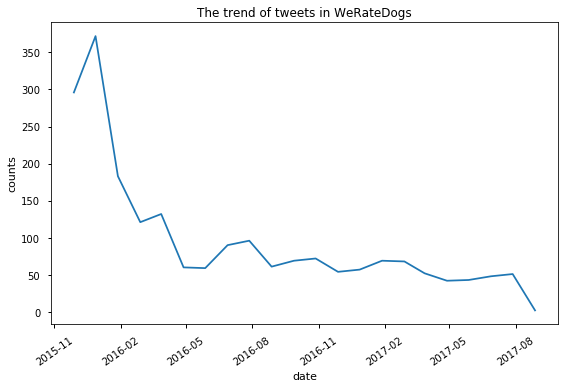

In [68]:
# get the counts of tweet grouped by year and month
x = twitters['datetime'].groupby([twitters["datetime"].dt.year,
                                  twitters["datetime"].dt.month]).count()

# transform it to dataframe
df = pd.DataFrame(x)
df.index = [datetime.datetime(year=int(y), month=int(m), day=28) for y, m in df.index]
df.index.names = ['date']
df = df.reset_index()
df = df.rename(columns = {'datetime':'count'})

# create a simple plot 
fig, ax = plt.subplots()
plt.plot(df['date'], df['count'])
plt.xticks(rotation=35)
plt.ylabel('counts')
plt.xlabel('date')
plt.title('The trend of tweets in WeRateDogs')

# save 
if not os.path.exists('plot'):
    os.makedirs('plot')

fig.tight_layout()
fig.savefig('plot/the_trend_of_tweets_in_WeRateDogs.png')

The number of tweets are calculated, and the trend is plotted as a time series. The peak of the number of tweets was at the beginning of WeRateDogs followed by a decay in the number of tweets. However, we cannot make a solid conclusion since the dataset we have is not the comprehensive and the recent tweets may have not recorded. Therefore, further investigation on the data completeness is required.

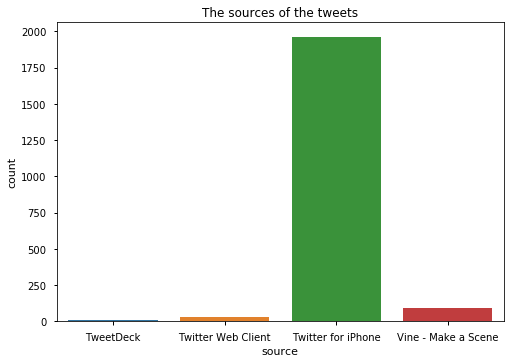

In [57]:
g = sns.countplot(twitters['source'])
g.set_title('The sources of the tweets')

The source of tweets from WeRateDogs are mainly from the Twitter for iPhone.

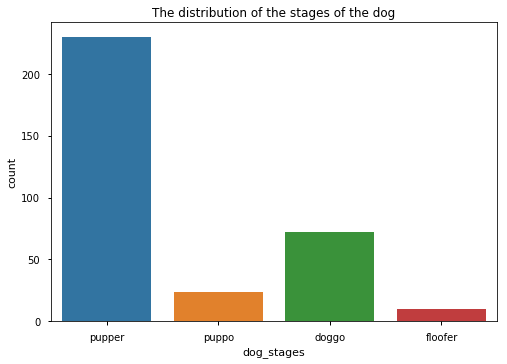

In [70]:
g = sns.countplot(twitters['dog_stages'])
g.set_title('The distribution of the stages of the dog')
fig = g.get_figure()
fig.savefig('plot/the_distribution_of_the_stages_of_the_dog')

The total sum of the tweets have the information about the stages of the dog is small (< 500), which suggests the stages of dog were not mentioned in most of the tweets or most of the information about the dog stages are lost. 

In [59]:
# outliers treament
def IQR(string, data):
    return data[string].quantile(0.75) - data[string].quantile(0.25)
    
def bound_conditions(string, data):
    cal_IQR = IQR(string, data)
    upper_bound = data[string].quantile(0.75) +1.5*cal_IQR
    lower_bound = data[string].quantile(0.25) -1.5*cal_IQR
    return (data[string] < upper_bound) & (data[string] > lower_bound)

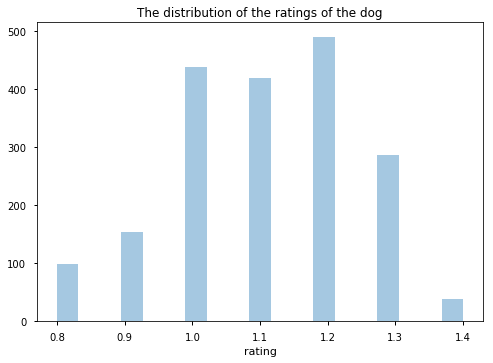

In [71]:
# create a new variable based on the rating numerator and denominator
twitters['rating'] = twitters['rating_numerator']/twitters['rating_denominator']

# conditions for outliers
rating_conditions = bound_conditions('rating', twitters)

# create a barchart for the ratings
g = sns.distplot(twitters[rating_conditions].rating, kde = False)

g.set_title('The distribution of the ratings of the dog')
fig = g.get_figure()
fig.savefig('plot/the_distribution_of_the_ratings_of_the_dog')

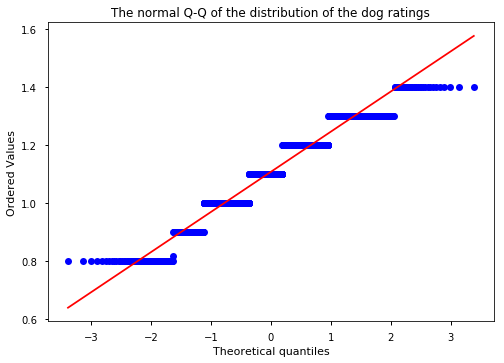

In [75]:
import scipy.stats as ss 
    
g = ss.probplot(twitters[rating_conditions].rating, plot=plt)
plt.title('The normal Q-Q of the distribution of the dog ratings')

plt.savefig('plot/normal_QQ_plot')

The rating in the tweets is calculated by dividing the rating numerator to the rating denominator. The outliers are ignored by setting the lower and upper of the data (1.5x IQR from the Q1 and Q3). 

We first plot the distribution of the dog ratings, and it is found that most of the ratings are 10, 11, and 12, which are around the median of the dog ratings. Then, a normal Q-Q plot is generated. We can see that without the outliers, the data distribution is close to a normal distribution. 

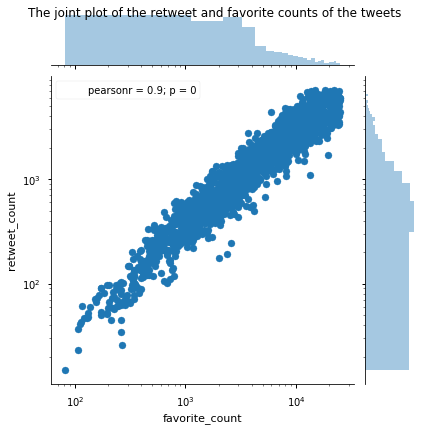

In [78]:
# conditions for outliers
fc_conditions = bound_conditions('favorite_count', twitters)
rc_conditions = bound_conditions('retweet_count', twitters)

data_subset = twitters[fc_conditions & rc_conditions]

# create a scatterplot between the retweet and favorite counts
g = sns.jointplot(x="favorite_count", y="retweet_count", data=data_subset)

# there are tweets have very large retweet and favorite counts
# a log scale is more suitable 
g.fig.get_axes()[0].set_yscale('log')
g.fig.get_axes()[0].set_xscale('log')

g.fig.suptitle('The joint plot of the retweet and favorite counts of the tweets')

g.savefig('plot/joint_plot.png')

A joint plot of favorite and retweet counts is generated. The distributions of these counts are not normal. These distributions are skewed towards the left suggesting only small fraction of tweets have a high favorite and retweet counts.  Then, we observe there is a strong correlation between the retweet and favorite counts with 0.9 in Pearson correlation coefficient.  

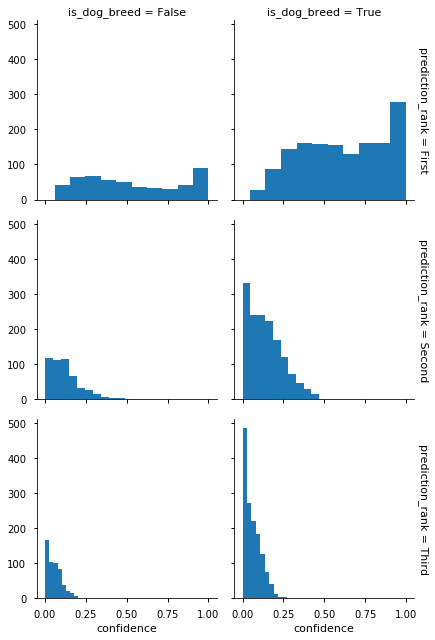

In [80]:
g = sns.FacetGrid(master, col="is_dog_breed", row="prediction_rank", margin_titles=True)
g.map(plt.hist, "confidence")
g.savefig('plot/grid_confidence.png')

The first predictions have a wide range of confidence (almost the entire space: (0,1)). On the other hand, the confidences on the second and third predictions are always low. Moreover, it is interested that the distribution of the confidences does not depend on the prediction result (is the result a dog breed?).

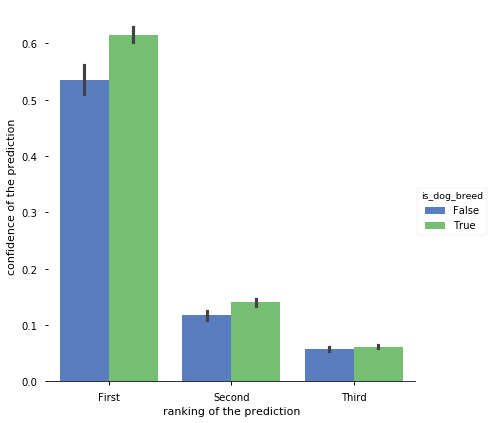

In [83]:
# Draw a nested barplot to show the confidence based on the ranking of the prediction and the prediction results
g = sns.factorplot(x="prediction_rank", y="confidence", hue="is_dog_breed", data=master,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g.set_ylabels("confidence of the prediction")
g.set_xlabels("ranking of the prediction")

g.savefig('plot/barchart_confidence.png')

Since the confidences of second and third predictions are more centralized than the first prediction. The standard derivation on the confidence of second and third predictions are smaller than the first prediction. However, on the other hand, the confidence of the first prediction is usually much higher than the second and third predictions.

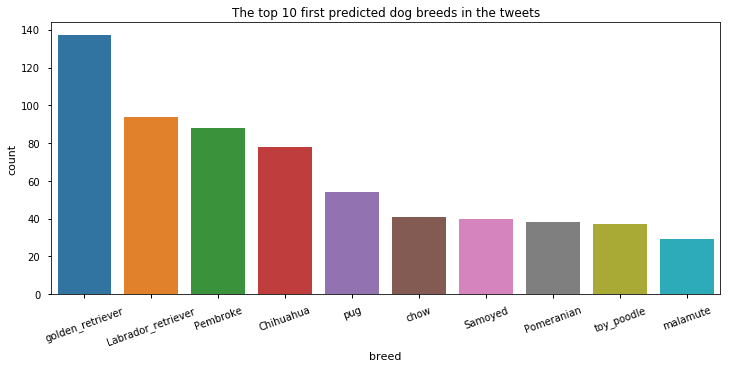

In [85]:
# the top five breeds in the first prediction
fig, ax = plt.subplots(figsize=(12,5))
g =sns.countplot(x="breed", data=master[master.prediction_rank == 'First'], 
              order=master[master.prediction_rank == 'First'].breed.value_counts().iloc[:10].index)
plt.xticks(rotation=20)
plt.title('The top 10 first predicted dog breeds in the tweets')
fig = g.get_figure()
fig.savefig('plot/top_10_dogs.png')

Using the first prediction from the neutral network model, we generate a plot of the top 10 predicted dogs in the tweets. If the algorithm of prediction is accurate, this plot may suggest the popular dog breeds among the twitter users.